In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers

from PIL import Image
import cv2
from glob import glob
import gc

from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
path = '/kaggle/input/datasets/adnanabdulfetah/lung-cancer/lung_image_sets'
classes = os.listdir(path)
print(classes)

['lung_aca', 'lung_scc', 'lung_n']


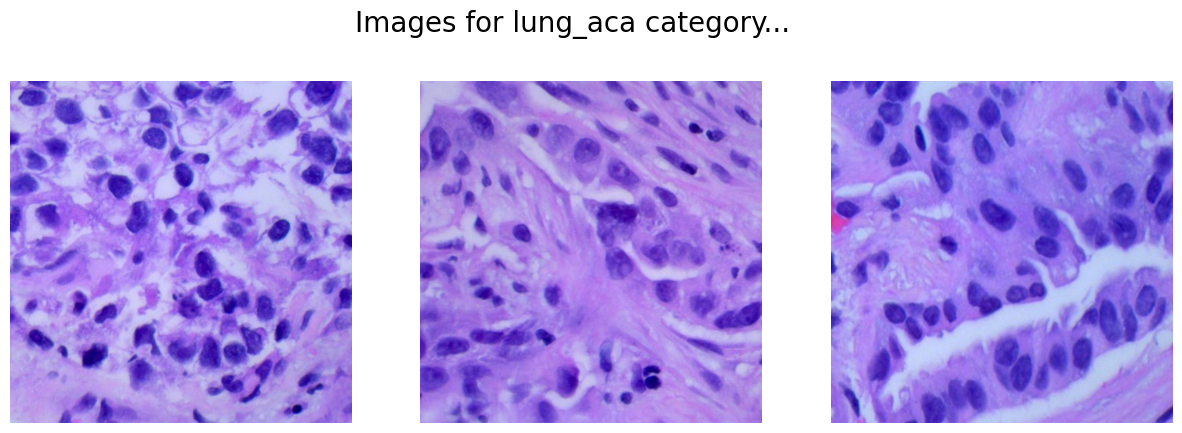

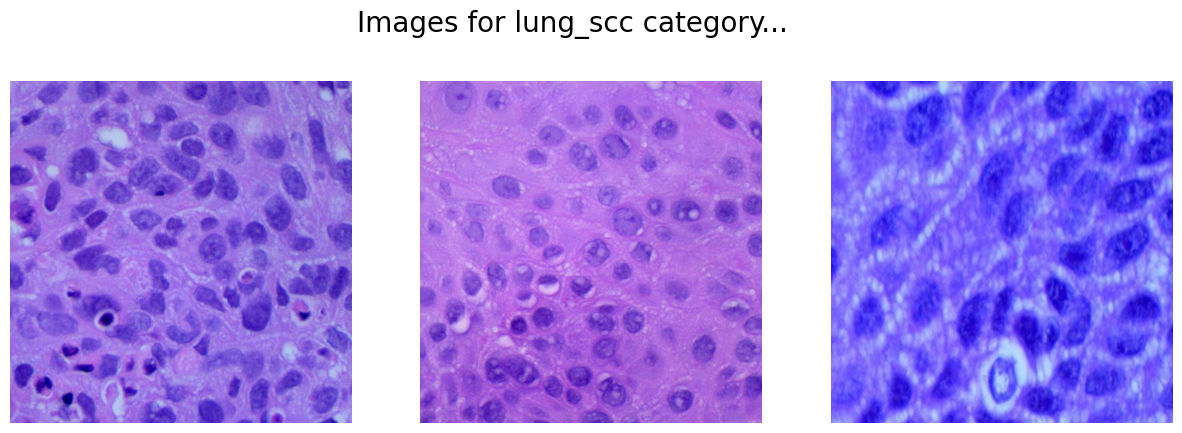

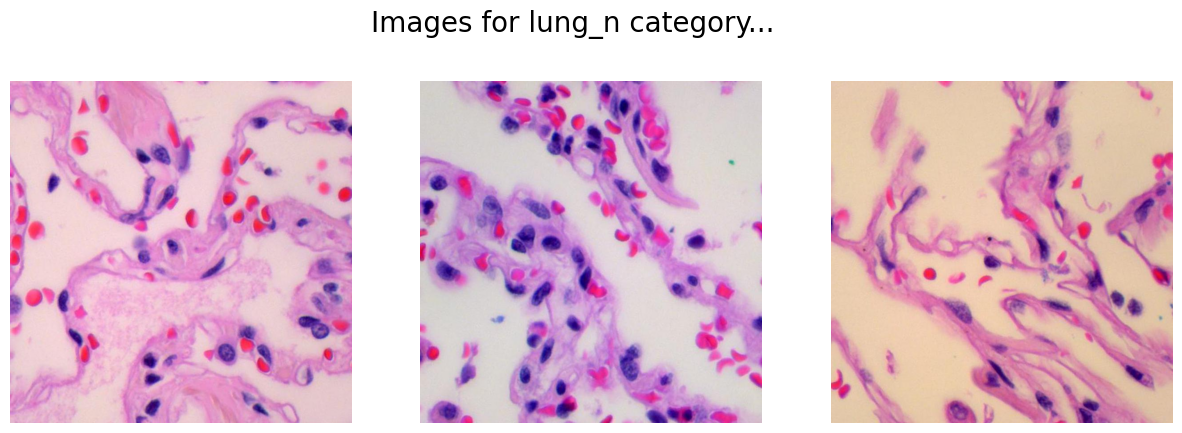

In [16]:
for category in classes:
    image_dir = f'{path}/{category}'
    images = os.listdir(image_dir)
    
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    fig.suptitle(f'Images for {category} category...', fontsize = 20)
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{category}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [17]:
img_size = 256

In [18]:
X = []
Y = []

for i, category in enumerate(classes):
  images = glob(f'{path}/{category}/*.jpeg')

  for image in images:
    img = cv2.imread(image)
    
    X.append(cv2.resize(img, (img_size, img_size)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = 0.2, random_state = 2026)

In [20]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pretrained_model = InceptionV3(
    input_shape = (img_size, img_size, 3),
    weights = 'imagenet',
    include_top = False
)

In [21]:
#freeze the weights
for layer in pretrained_model.layers:
    layer.trainable = False

In [25]:
last_layer = pretrained_model.get_layer('mixed7')
output_shape = last_layer.input[0].shape
print('last layer output shape: ', output_shape)
last_output = last_layer.output

last layer output shape:  (None, 14, 14, 192)


In [31]:
x = layers.Flatten()(last_output)

x = layers.Dense(256, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)

output = layers.Dense(3, activation = 'softmax')(x)
model = tf.keras.Model(pretrained_model.input, output)

In [32]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [40]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get('val_accuracy') > 0.95:
      print('\n Validation accuracy has reached upto 90%\
      so, stopping further training.')
      self.model.stop_training = True

es = EarlyStopping(patience = 3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)

lr = ReduceLROnPlateau(monitor = 'val_loss',
                       patience = 2,
                       factor = 0.5,
                       verbose = 1)


In [41]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = 64,
                    epochs = 10,
                    verbose = 1,
                    callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9568 - loss: 0.1100

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 3)

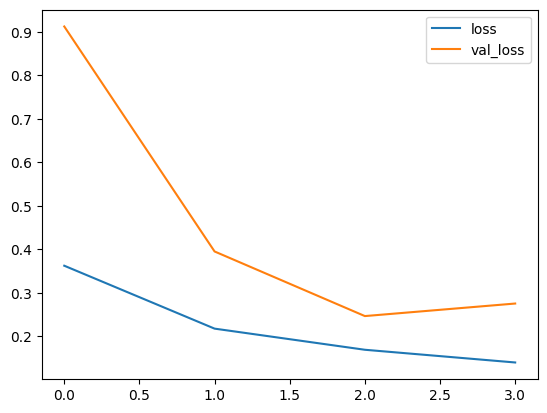

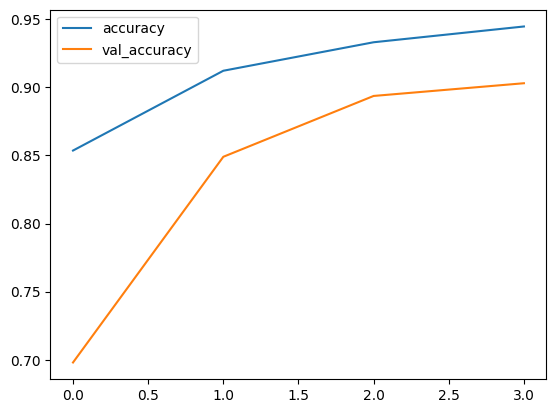

In [35]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [36]:
Y_pred = model.predict(X_val)

Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step


In [37]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[795, 220,   6],
       [ 18, 943,   0],
       [ 38,   9, 971]])

In [38]:
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.93      0.78      0.85      1021
    lung_scc       0.80      0.98      0.88       961
      lung_n       0.99      0.95      0.97      1018

    accuracy                           0.90      3000
   macro avg       0.91      0.90      0.90      3000
weighted avg       0.91      0.90      0.90      3000

